In [42]:
import os
import shutil # move files and delete folders with files
import tarfile
import urllib.request # download files folder
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import IPython.display as ipd
import librosa, librosa.display
import midi
import pygame # execute midi files
import re
import IPython # listen to sounds on Python

from scipy.io import wavfile
from scipy.spatial import distance_matrix
from matplotlib import colors
from itertools import product
from hmmlearn import hmm
from sklearn.metrics import f1_score
from utils.annotations import read_simplify_chord_file
from utils.hmm_helper import calc_transition_prob_matrix
from utils.files_processing import download_uncompress_data_to_local, \
                                   filter_lab_files, \
                                   delete_download_file, \
                                   delete_download_folder
from utils.signal import plot_signal, \
                         plot_spectra, \
                         stft_audio, \
                         calc_chromagram, \
                         chromagram_2_dataframe, \
                         get_frame_stats, \
                         get_annotated_chord_sequence


%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Notebook for Pydata 2019 conference - https://de.pycon.org/program/pydata-yxndb9-hidden-markov-models-for-chord-recognition-intuition-and-applications-caio-miyashiro/

# Intro

Welcome to the workshop! Today, you will learn the concept of **Hidden Markov Models (HMM)**, which is a probabilistic framework to work with sequence data, such as speech and language processing and GPS positions. The main idea is to show everyone What is a HMM and provide them with sufficient basis so you can use it in your next projects. The concept will be presented with a specific story and application in music:

* "Given an input music signal, can we identify which chords were played and in which sequence?"
  
After this talk, I hope you'll be able to explain in common language what is a HMM, how it works and mainly, how you can use it next time you work with your sequence data (and learn a little about the best band in the world - The Beatles :-)). So lets go!

## Context

Chord recognition is one task from the field of Music Analytics [[1]](https://www.amazon.com/Music-Data-Analysis-Foundations-Applications/dp/1498719562), where we want to automatically extract characteristic features from musical pieces. For instances, besides chords, we could work to extract characteristics of tempo, key or instruments from our musical signal.  
  
Imagine you're listening to youtube and suddenly hear a music that you enjoy. A lot. You feel you want to take your guitar and play around with your family and friends. However, as you search on the internet, you find no suitable chords on that song or any how-to-play that could make your get-together happier. What now?  
  
Imagine then being able to record the audio with your cellphone (or just send the youtube link) and have all the chords you needed in a few seconds. Your party is saved!  
  
Although the idea is simple, extracting information from music signals is still a big challenge. Music is a complex signal. Multiple voices, instruments and pre and post signal processing makes it difficult that we can get the features we want. Therefore, in order to work in our chord recognition problem, we need to understand a few processing techniques that'll make our lives "easier" for the task. But, first of all:

# How is sound stored and represented by a computer?

Lets take a clear sound of a piano playing a A3 and print it:

In [2]:
# https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.io.wavfile.read.html
Fs, x = wavfile.read("sounds/pianoA3.wav") 
IPython.display.Audio(x, rate=Fs)

The signal is represented with time on the x-axis and amplitude on the y-axis, where amplitude could be seen as the air pressure compression.

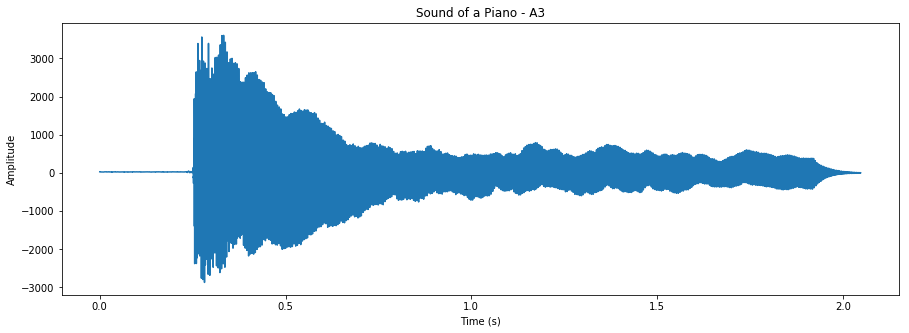

In [3]:
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams["font.size"] = 10

plot_signal(x, Fs, title='Sound of a Piano - A3', xlabel='Time (s)', ylabel='Amplitude')

**Zoomed Signal:**

If we look close enough, we can see that the signal is quite periodic. This periodicity represent one of the most basic sound qualities: the periodic variation of air pressure. In a micro scale, sequences of compressed and rarefied air reach our internal ears and are captured by highly specialised muscles, which turn them into electrical signals and finally into our perception of what a sound is. Check out this really cool summary on this Youtube Video - ["What is up with Noises? (The Science and Mathematics of Sound, Frequency, and Pitch)"](https://www.youtube.com/watch?v=i_0DXxNeaQ0).

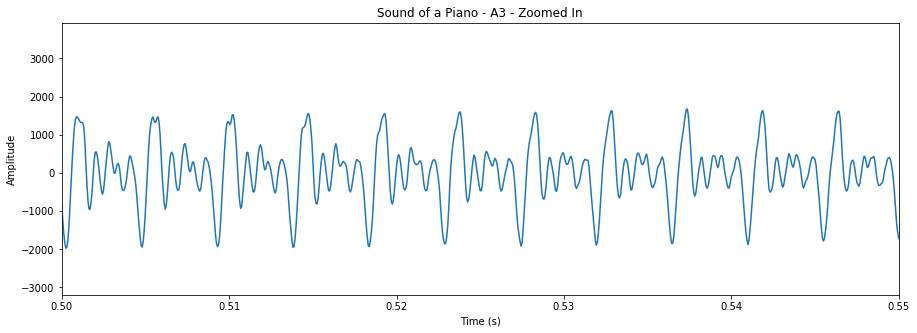

In [4]:
plot_signal(x, Fs, title='Sound of a Piano - A3 - Zoomed In', xlabel='Time (s)', ylabel='Amplitude')
plt.xlim([.5,.55]);

# From Time to Frequency Domain - The Fourier Transform (FT)

In western music, when we play a chord in our instrument, we are playing a set of specific notes. For instance we can differentiate a C minor from a C major by it's third (E or Eb). But, what if we could decompose any kind of sound in its respective notes (frequencies)? That's basically the Fourier transform. Despite its fancy name, this transformation basically just answer you the following question: "`What are the frequencies that, together, compose the sound I'm seeing?`"

<img src="images/fourier.gif" style="height:100">  

<center><a href=http://mriquestions.com/fourier-transform-ft.html>http://mriquestions.com/fourier-transform-ft.html</a></center>

Ok, when I said "*just answer x*" I was trying to make things simpler as they seemed. Let's take two examples of what the transformation can show us, lets hear two sounds, a whistle and a piano note, and lets see their Fourier transformation. If you don't want to understand the code below, it just takes the sound signal, perform the Fourier transform and plot the result, showing which frequencies (x-axis) are present in the signal:  
  
  
## Whistle

The whistling is at an A5, which is around [~880Hz ](http://pages.mtu.edu/~suits/notefreqs.html). When we perform the fourier transform on it, we can that the highest peak is at this frequency. There is some energy amplitude also around the peak frequency and that's probably because we don't produce a perfect A5 whistle, but rather some variational and approximated version of it.  

In [5]:
Fs_2, s_2 = wavfile.read("sounds/whistleA5.wav")
IPython.display.Audio(s_2, rate=Fs_2)

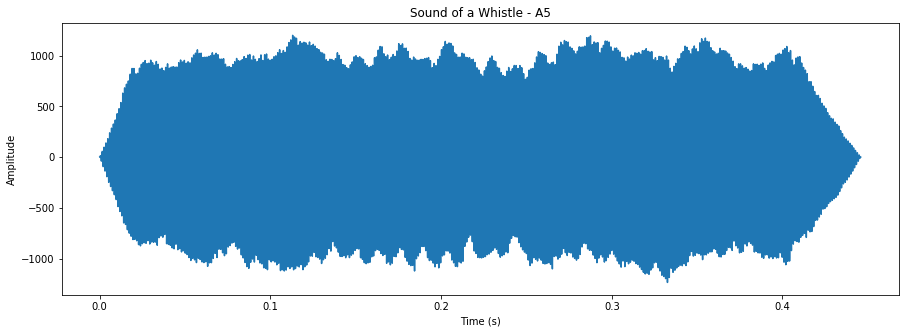

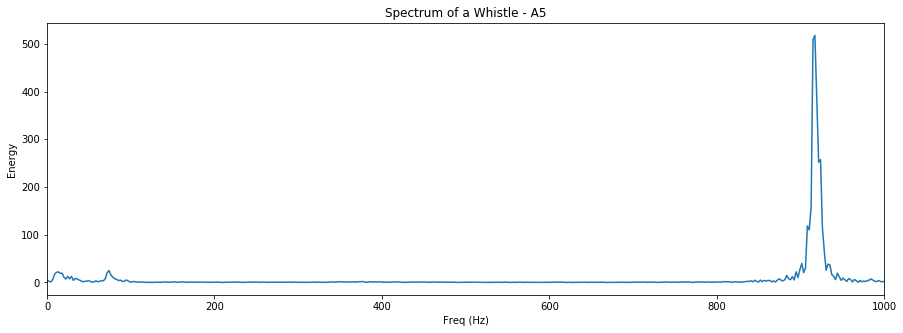

In [6]:
plot_signal(s_2, Fs_2, title='Sound of a Whistle - A5', xlabel='Time (s)', ylabel='Amplitude');
plt.show()
plot_spectra(s_2, Fs_2, max_freq=1000, title='Spectrum of a Whistle - A5', xlabel='Freq (Hz)', ylabel='Energy')

## Spectrum for Piano

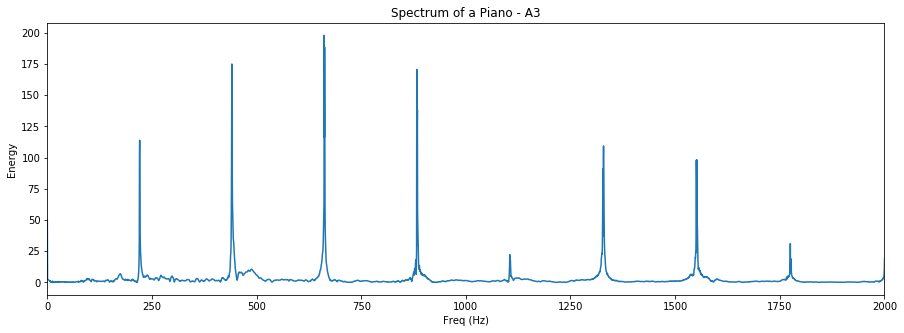

In [7]:
plot_spectra(x, Fs, title='Spectrum of a Piano - A3', xlabel='Freq (Hz)', ylabel='Energy', max_freq=2000)

Here we see how supposedly simple things already starts to complicate...Even though we will hear a single piano note, it frequency properties aren't as simple as the whistle sound, as it contains a diverse of [harmonics](https://en.wikipedia.org/wiki/Harmonic), *i.e.*, frequencies made of multiples from the original frequency. This frequently happens on (not only) string instruments, as the string oscillates on it's main frequency but each half of it also oscillates on a doubled frequency and so on. A good reference on string harmonics can be found [here](https://flypaper.soundfly.com/features/the-weird-and-creepy-world-of-string-harmonics) and a really nice video can be seen [here](https://www.youtube.com/watch?v=O1-CRFcX980).

<img src="images/harmonics.jpg" style="height:100">  
<center><a href="https://flypaper.soundfly.com/features/the-weird-and-creepy-world-of-string-harmonics/">https://flypaper.soundfly.com/features/the-weird-and-creepy-world-of-string-harmonics/</a></center>

The note we're playing is an A3, which have the fundamental frequency of ~220 Hz, but we see peaks of frequencies on 440, 660, 880 and so on. One interesting observation is that the main note doesn't necessarily has the biggest peak of between it and its harmonics.  
  
# Short Time Fourier Transform (STFT)

When we take a FT of a signal, it takes a "picture" of it and extract the frequency components out of it. This is good when we want to analyse the signal as a whole. However, sometimes we want to evaluate parts of it in sequence, such as in chord recognition, where the chords in a time window **will** be different sometime in the past or in the future. In order to have the fourier features for different parts of the music signal, we segment it in windows and apply the FT to each one of them: The STFT.  
  
Lets take an example. If we hear the melody below, we clear hear different pitches being whistled in sequence. However, if we take the FT of it, all frequencies will appear on the same "picture" and we'll lose information of who occurred first.  

In [8]:
Fs_3, s_3 = wavfile.read("sounds/whistleMelody.wav")
IPython.display.Audio(s_3, rate=Fs_3)

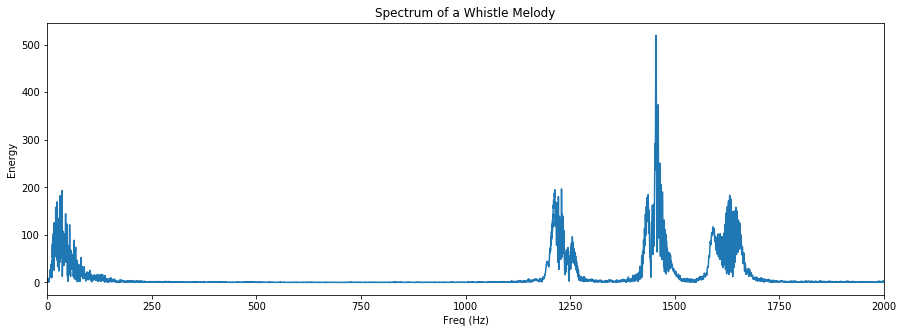

In [9]:
plot_spectra(s_3, Fs_3, title='Spectrum of a Whistle Melody', xlabel='Freq (Hz)', ylabel='Energy', max_freq=2000)

In order to visualise the STFT we need a different approach than FT. STFT has a new time dimension, while keeping the same frequencies dimensions from the FT. If we "bring" the right hand side of the FT plot (like above) to the top and concatenate them side by side, being each new item a FT of a time window, we can visualise this kind of information.   

* **X axis** will be time
* **Y axis** is the frequency
* color (**Z-axis**) is the energy, *i.e.*, the peak heights from the previous FT plots:

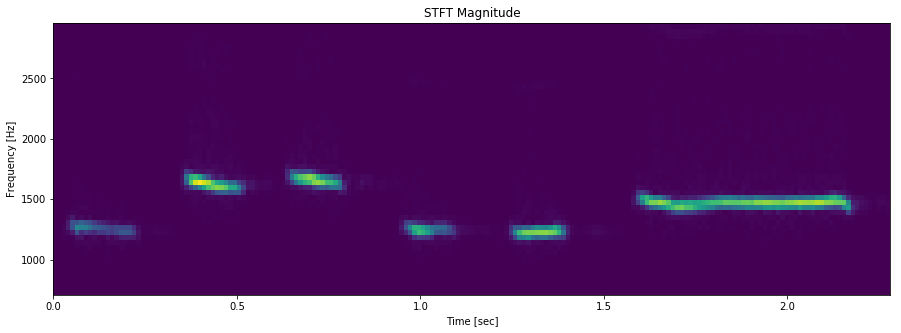

In [10]:
_, _, _ = stft_audio(s_3, Fs_3, True)

# Hands on 1:

Using the two functions above:
* `wavfile.read`
* `stft_audio`

read, apply STFT and interpret a simple melody file. For examples, you can look at [https://freesound.org/](https://freesound.org/) and search for the instruments you're interested to look at.  
  
A cool think is to find instruments that produce harmonics, like any string instrument, and others that don't, such as flute (almost) and check their STFT. Can you identify the frequencies and their notes played? A table connecting frequencies to pitches can be accessed [here](http://pages.mtu.edu/~suits/notefreqs.html).  
  
# What are Chords?

<img src="images/Natural-Minor-Chords.png" style="height:100">  
<center><a href="https://www.musical-u.com/learn/discovering-minor-chord-progressions-minor-chords-part-one/">https://www.musical-u.com/learn/discovering-minor-chord-progressions-minor-chords-part-one/</a></center>

We've talked a lot on the theory of the FT and STFT but not about our main task objective on identifying chords. After all, `what are chords?`.  
  
Chords are a set of 3 or more notes played together [[2]](https://www.coursera.org/learn/edinburgh-music-theory). These 3 notes are usually related to each other somehow (you can't play random 3 notes and call it a chord) and, depending on the notes choice made, they will have a specific role in your music, more specifically, in western music.  
  
The most common chords in western music are the major and minor chords. Possibly, any music could be composed by just using them and most instruments are capable of producing them, except melodic instruments such as violins or flutes.   
Chords can be pictured on a FT as multiple peaks from different notes played or as parallel lines in a STFT



## Features from STFT for Chord Recognition - Chromagram
  
As we learned, pitches are made by sinusoids in a specific frequency. Besides, pitches have a periodic naming, *i.e.*, from notes A to G, we come back to A2 until G2 and so on. Because of this feature, we can actually sum up the frequencies that belong to the same pitch. If we do that, we can have an idea of how much of each "note" we had on that time window, and this will be the **main feature** that will be used for our chord recognition problem.  
  
The technique takes the STFT of the music signal and, together with a [table connecting frequencies to pitches](http://pages.mtu.edu/~suits/notefreqs.html), if finds the energy of the overall pitch representation, sum them up and normalise them so the energy values stays between the interval [0,1].  
  
You can take a better look at the [chromagram function](https://librosa.github.io/librosa/generated/librosa.feature.chroma_stft.html) from [Librosa](https://librosa.github.io/librosa/index.html), which is the function we use to extract our chroma features.
  

In [11]:
COL_NAMES_NOTES = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

In [33]:
let_it_be_intro_path = 'sounds/Let it Be Intro.wav'
x, Fs = librosa.load(let_it_be_intro_path)
ipd.display(ipd.Audio(x, rate=Fs))

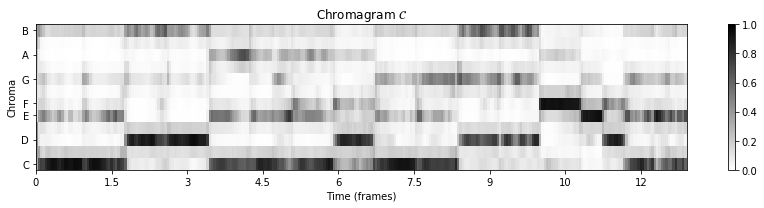

In [13]:
_ = calc_chromagram(x, Fs)

We can see that until the first ~1.5 seconds, there is a predominance of the C, E and G notes (and a little of B). This set of notes compose the music's initial chord, a **C major** chord. There is energy spread around other notes in a smaller way, which are probably harmonics from the three actually pressed key notes of the piano.  It seems it could be easy to identify the chords based on the chromagram. However, if we look at the following chord, there is a lot of energy around D, some more on B and almost nothing on G. This chord is actually a **G major** chord, but the D note was the lowest note in pitch on this chord, *i.e.*, an inverted chord. Therefore, we can't just look at the note with the biggest energy on it in order to classify the chord, we need more evidences. As it turns out, among chords, there's a high dependency of the current chord over the previous one **(*)**, so we need a tool that helps us to deal with that, so next we'll introduce `Markov Chains` and `Hidden Markov Chains`.  
  
(*) you can read more about chord dependency on western music Harmony, more specifically on [chord progressions](https://en.wikipedia.org/wiki/Chord_progression), but we're not going to cover it in this workshop

# Intro to Markov Chains - MC

<img src="images/markov_model.png" width="500">  
<center><a href="https://hackernoon.com/from-what-is-a-markov-model-to-here-is-how-markov-models-work-1ac5f4629b71">https://hackernoon.com/from-what-is-a-markov-model-to-here-is-how-markov-models-work-1ac5f4629b71</a></center>

**What is the chord on this time window given its chromagram and that the previous chord is a C major?**

This is the new adapted question for our original task on chord recognition. We've already seen how just using the chromagram as main features is not enough, as chords can have inversions and actually sometimes the [harmonics]( #Spectrum-for-Piano) effect can create enough noise to hide the main chord notes. Before we use the MC for our problems lets explain how it works with an easier example. For this, I'll mainly use the great explanation of [[3]](https://hackernoon.com/from-what-is-a-markov-model-to-here-is-how-markov-models-work-1ac5f4629b71) and create a simple MC over the following sentence in order to predict the next word, similar to our chord prediction definition:

> "One fish two fish red fish blue fish." <cite> -Dr. Seuss 🎩 </cite>
  
1. Adapting a little bit with some terms that are there but just hidden: 

> "-START- One fish two fish red fish blue fish -END-." <cite> -Dr. Seuss 🎩 </cite>  

One of the main features/assumptions of a MC is that the `current state of the model only depends on the **previous state** and not the ones that occurred before it`. Each state on this example can be a word and, in our problem, it would be a chord.  

If we want to predict the next word, given the immediately previous one, we can process our sentence so we see this kind of relationship:

<img src="images/markov_model_tokens.png" width="500">  
<center><a href="https://hackernoon.com/from-what-is-a-markov-model-to-here-is-how-markov-models-work-1ac5f4629b71">https://hackernoon.com/from-what-is-a-markov-model-to-here-is-how-markov-models-work-1ac5f4629b71</a></center>  
  
Considering only this sentence, if you saw the token <START>, you would be sure that next word is `One`. However, if you saw the word "fish", then the possible next words could be `two`, `red`, `blue` or `<END>`, *i.e.*, there'll be more uncertainty over this word. We can represent this uncertainty by a graph and show what are the possibilities of going from one word to another and, in case there are more possibilities, we can generate the probabilities for those events:
    
<img src="images/markov_models_graph.png" width="500">  
<center><a href="https://hackernoon.com/from-what-is-a-markov-model-to-here-is-how-markov-models-work-1ac5f4629b71">https://hackernoon.com/from-what-is-a-markov-model-to-here-is-how-markov-models-work-1ac5f4629b71</a></center>  
  
Now, imagine the same for our music problem. We look at some music sheet, record this chord *x* chord interactions and plot the same kind of graph. We could end up with something like this:   
  
<img src="images/markov_model_chord_graph.png" width="500">  

As we only analysed one music, we only have 1 C major chord after -START-. From there, we can go and go back to different chords until we end up at -STOP- and stop our chords prediction.  
  
With a MC, if we have an initial chord, we can then predict what could be the next ones based on the previous chord. This would be already good, **if** we had the exact name of the played chord at hand. Remember that the input for our task today was a music signal. Behind those amplitudes and energies, the chord change chain is running behind it, "*hidden*". In order to be able to connect our chord chain with the windowed music signal, we need a extra feature, which is the feature of `Hidden Markov Models`.

# Hands on 2  
  
?  

# Hidden Markov Models - HMM

<img src="images/hidden_markov_model_summary.png" width="500">
<center>Summary of main features of a Hidden Markov Model</center> 


Examples will be adapted from [[4]](https://web.stanford.edu/~jurafsky/slp3/8.pdf) and [this](https://www.youtube.com/watch?v=kqSzLo9fenk) youtube tutorial.  
  
"A Markov chain is useful when we need to compute a probability for a sequence of observable events. In many cases, however, the events we are interested in are hidden hidden: we don’t observe them directly. For example we don’t normally observe part-of-speech tags in a text" [[4]](https://web.stanford.edu/~jurafsky/slp3/8.pdf). Rather, we see audio signals, and must infer the chords out of it. We call the sequence hidden because they are not observed.  
  
The HMM will allow us to add the features to our observation and keep with the same framework of that MC. You can check out the mathematical formulation for HMM at the [Appendix](#Appendix) section but here we will stay with the main intuitions.  
  
The main answer that a HMM can give us is:
* What is the most probable sequence of chords for a given sequence of observations?  

In order to answer this question we will need a few things from the MC and some new features:
1. Chord Transition Probability Matrix: These are the word probabilities explained in the MC section but having the chord transition probabilities instead.
2. Probability of an observation belong to each one of the chords $\mathbb{P}(chord|observation)$: In technical terms, this is called *emission probabilities*.  
  
However, where we're going to extract these data from?  

# Annotation + Music Data - The Beatles

In order to be able to generate the probabilities above, we need:
* The music files in order to extract the chromagrams
* An annotaded dataset, so we can join the chord labels with the corresponding windowed chromagrams. 

For the musics, we can obtain the music files by purchasing them online. For this workshop I'll be providing the files :)  
  
For the annotaded dataset, luckily, some researches invest time on creating and publishing them, so they can be used as standards for a specific research domain or used as machine learning models tasks baselines. Here, we'll investigate the dataset generated by Harte (2010)[[5]](https://code.soundsoftware.ac.uk/attachments/download/330/chris_harte_phd_thesis.pdf). Harte, together with other musicians and researches, manually extracted features from 120 musics from The Beatles, including beats, key changes and chords. You can download all annotations on their [website](http://www.isophonics.net/content/reference-annotations-beatles)
  
Specifically looking at chords, we'll look at .lab files, which tell us, from which second until which second, which chord the music was in. Lets download, process and take a quick look at the files:

## Download Annotations

In [14]:
ORIGINAL_FOLDER = 'Beatles Annotations'
DEST_FOLDER = 'Processed Beatles Annotation Files'

if(not os.path.exists(DEST_FOLDER)): # if processed folder doesn't exist
    download_uncompress_data_to_local(DEST_FOLDER) # download from standard beatles file url
    filter_lab_files(ORIGINAL_FOLDER, DEST_FOLDER) # filter only for chord files .lab

    # Delete temporary files
    delete_download_file(f'The {ORIGINAL_FOLDER}') # delete compressed and extra files
    delete_download_folder(ORIGINAL_FOLDER)        # delete folder of extra files
    print(f'Files successfully downloaded to "{DEST_FOLDER}"')
else:
    print(f'File {DEST_FOLDER} already exists')

File Processed Beatles Annotation Files already exists


## Read and Simplify Annotations

Chords can be complex and subjective some times. In western music theory, chords can have functions and, even though a C# chord consist of exactly the same notes of a Db, in theory, they influence the music with different "functions" or emotions so to say. In order to simplify our problem, we'll only work with the main types of chords, major and minor chords. We'll exclude, for example, 7th chords or diminished or augmented chords. This will make it easier for our HMM understand and predict chords. In order to understand what we want to do with all files and music files and also to check if our assumptions for our task for today works, I'll show an example with one file first:

In [15]:
lab_file_path = f'{DEST_FOLDER}/06_-_Let_It_Be.lab'
chords_annotation = read_simplify_chord_file(lab_file_path,process_silence=True)
chords_annotation.head()


,start,end,chord
0,0.000000,0.175157,C
1,0.175157,1.852358,C
2,1.852358,3.454535,G
3,3.454535,4.720022,A:min
4,4.720022,5.126371,A:min


## Calculate framed Chromagram and join with chord labels

Now that we have the annotations with the time period that which chord was played on a music, we need to join it with our chromagram features so we can "train" our HMM. The idea is to create a definition of "what is a C Major chord in a chromagram" so we can create then our **emission probabilities**.  
  
Before merging our chromagram with the annotation files, we need to know how much time each of our chromagram windows takes in order to be able to merge. For that, we first use the function `get_frame_stats`, sending the windowed chromagram, the signal and its sampling frequency in order to know how many seconds each window is.  
  
With these informations, we can then say which chord was being played in each one of the windows.

In [36]:
x, Fs = librosa.load(let_it_be_intro_path)
let_it_be_chromagram = calc_chromagram(x, Fs, plot=False)
frames_per_sec, frame_duration_sec = get_frame_stats(chromagram=let_it_be_chromagram,
                                                     signal=x, 
                                                     Fs=Fs)

pcp = chromagram_2_dataframe(let_it_be_chromagram, frame_duration_sec)

pcp['chord'] = get_annotated_chord_sequence(pcp, chords_annotation)
pcp.head()

,C,C#,D,D#,E,F,F#,G,G#,A,A#,B,start,end,chord
0,0.332066,0.384424,0.431916,0.414366,0.131415,0.091793,0.108283,0.152824,0.190040,0.224761,0.313280,0.371681,0.000000,0.046419,C
1,0.664177,0.352761,0.109753,0.110625,0.366218,0.163517,0.087432,0.182613,0.090595,0.068443,0.157639,0.412985,0.046419,0.092837,C
2,0.754787,0.184479,0.045408,0.124241,0.429377,0.168346,0.106199,0.206016,0.082103,0.026816,0.040539,0.321305,0.092837,0.139256,C
3,0.734501,0.146538,0.047722,0.111363,0.507049,0.167623,0.137559,0.243638,0.065114,0.015817,0.024087,0.236238,0.139256,0.185674,C
4,0.833918,0.198937,0.056337,0.078762,0.421176,0.114144,0.089199,0.182769,0.042916,0.006769,0.013399,0.147586,0.185674,0.232093,C


## Calculate State Transition Matrix

We're finally ready to calculate our first needed matrix: **Transition Probability Matrix**, *i.e.*, the probability of changing from one chord to another from window to window.

For this, we'll use the `calc_transition_prob_matrix`, which will run through all our chord in the dataframe and count all chord-to-chord transitions that it sees. Finally, in order to become a probability, we will normalise all values so the probabilities of going from one chord to all others is always 1.

In [43]:
transition_matrix = calc_transition_prob_matrix(pcp)
transition_matrix
    

sequence_chord,A:min,C,F,G
initial_chords,,,,
A:min,0.972222,0.000000,0.027778,0.000000
C,0.000000,0.980198,0.000000,0.019802
F,0.000000,0.028169,0.971831,0.000000
G,0.014493,0.000000,0.014493,0.971014


## Emission Probabilities 

If you recall from the [intro to HMM](#Hidden-Markov-Models---HMM), the emission probabilities connect our observations (visible) with our probabilistic network (hidden), showing the probability of an observation belonging to a state (chord) $\mathbb{P}(obs|state)$. In order to calculate them, we have to think differently based on the type of the observation we have:  
  
* **Categorical**: Observations have distinct values. For example, classifying the weather based on people's emotion, such as sad, neutral or happy (example [here](https://www.youtube.com/watch?v=kqSzLo9fenk)).  
   
* **Continuous**: Observations can take numerical, or multi-dimensional numerical, fields. The example of chord recognition is this case, where our observations are the energies of each note present on the chromagram and can have any number in between a pre-defined scale.  
  
### Emission Probabilities for categorical observations

When we deal with categorical observations, the task of calculating $\mathbb{P}(obs|state)$ is based on counting the relationship between each observation and the corresponding state. Remember that a HMM attributes a state to every observation in the sequence. So, for example, if we have the amount of times that I observed the following relationship frequencies in my **historic database**:  
* Sad: {'Sunny': 100, 'Rainy':400}
* Neutral: {'Sunny': 300, 'Rainy':300}
* Happy: {'Sunny': 500, 'Rainy':100}  

We just need to normalise our counts so we can have our **emission probabilities**. So first we calculate the sum of each variable as a normalisation factor:
* Sum of observations in "Sad"     = 100 + 400 = 500
* Sum of observations in "Neutral" = 200 + 200 = 400
* Sum of observations in "Happy"   = 500 + 100 = 600  
  
And apply the normalisation factor to our conts in order to have probabilities:  
  
* Sad: {'Sunny': 100/500, 'Rainy':400/ 500}
* Neutral: {'Sunny': 200/400, 'Rainy':200/400}
* Happy: {'Sunny': 500/600, 'Rainy':100/600}  
  
=  
  
* Sad: {'Sunny': 0.2, 'Rainy':0.8}
* Neutral: {'Sunny': 0.5, 'Rainy':0.5}
* Happy: {'Sunny': 0.83, 'Rainy':0.17} 

### Emission Probabilities for continuous observations  

With continuous variables, there is no count that we can do in our historical database. For instance, if we were trying to predict the weather given the temperature. We wouldn't have only 3 states, like "Sad", "Neutral" and "Happy" as in the example above, but instead, we'd have many (infinite) possible different observations that related to "Sunny" or "Rainy", like these 3 examples:
* $\mathbb{P}(temp=20.7|sunny)$ **or** 
* $\mathbb{P}(temp=20.07|sunny)$ **or**  
* $\mathbb{P}(temp=20.007|sunny)$ **and so on...**  
  
In this cases, we need to do some **prior** assumptions on how our states looks like considering our variables of interest, such as *temperature* in this example.

> "Summer days in São Paulo - Brazil tend be between 30 and 40 degrees celsius"   
  
> "Winter is a summer day that didn't work. Temperatures can be between 15 to 25 degrees celsius"  
  
We usually have this kind of talks with our international friends explaining some general rule about a system. We usually speak about it based on our previous experiences and/or generalisation process. If we wanted to have the same ideas about a country that we haven't been yet, what could we do?  
  
* One thing to do would be to take temperatures online from a weather website, observe it for different weathers and create such temperature interval (or more generically, $assumption$) based on the data you have. Then, if you observe a temperature on a new day, you'd be able to make an educated guess of how the weather could look like. But still, **how to calculate probabilities on this continuous variables?**  
  
<img src="images/normal_distributions_.png" width="300">
<center>Example of Probability Distribution for Temperature</center> 

If we're calculating probabilities over continuous variables, we have to assume our data follows a specific distribution. For this chord recognition task and this temperature example, we'll assume that our observations follow a **normal distribution** [[6]](https://pt.coursera.org/lecture/probability-intro/normal-distribution-M71Nv).  Assuming a normal distribution for our temperature example states that:
* The temperature on different weather statuses has an average temperature
* The temperature can vary around this mean value, and the scale of the deviation from the mean value is defined by its variance.  

and the formula to calculate the probability of observing a temperature (close to) $t$ given the weather $w$ defined by its mean $\mu_{weather}$ and variance $\sigma^{2}_{weather}$ is: 

$$\mathbb{P}(t|\mu_{weather}, \sigma^{2}_{weather}) = \frac{1}{\sqrt{2\pi\sigma^{2}}} e ^{-\frac{(t-\mu)^2}{2\sigma^{2}}}$$  
  
oooor we call the equivalent python function in [scipy.stats.norm.pdf](https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.stats.norm.html) to check for that :D  

### Emission probabilities for chords and chromagrams  
  
The temperature example could work if we only had 1 variable for every state. Instead, in our chromagram, we have 12 variables, the energy of each one of the notes of the chromatic scale (A, A#, B, C and so on...). How do we do a probability of 12 variables belonging to a certain chord?  

Lets think on the question, "What is the probability of a chromagram showing a C major?". In this case, we'd expect a high energy on the notes C, E and G (major triad) and supposedly nothing else. The C major chord expect that the three notes have a high energy and expect that, if one is higher than another, which could happen, the chord would have some tolerance because it knows the energy of each note can vary **and** the energy on one note compared to other notes can also vary. In this case, the 12-variables probability distribution is just an generalisation of the original normal distribution we've seen, called [**multivariate gaussian distribution**](https://en.wikipedia.org/wiki/Multivariate_normal_distribution). Instead of having one expected $\mu$ and $\sigma^{2}$ for each chord, we'll have a set of 12x $\mu$ and a set of $\sigma^{2}$ for each note and an extra statistic showing how the notes' energies vary among themselves, called covariance.  

In the same way for one dimension, calculating the probability $\mathbb{P}(chromagram|\mu_{chord}, \sigma^{2}_{chord})$ has a specific (hard) [equation](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Density_function). Lucky for us, we'll leave this responsibility to the HMM package we're going to use, so we just need to calculate the multivariate gaussian parameters. So lets go for it:

## Calculate  Emission Probabilities 

In [13]:
def __get_mu_array(note_feature_vector):
    return note_feature_vector[COL_NAMES_NOTES].mean()

def get_mu_sigma_from_chroma(pcp):
    mu_array = pcp.groupby('chord').apply(__get_mu_array)

    states_cov_matrices = []
    for name, group in pcp.groupby('chord'):
        states_cov_matrices.append(group[COL_NAMES_NOTES].cov().values)
    states_cov_matrices = np.array(states_cov_matrices)
    
    return [mu_array, states_cov_matrices]

mu_array, states_cov_matrices = get_mu_sigma_from_chroma(pcp)

# Calculate Initial State Probability Matrix

* normalised value counts of every first chord from **all** musics

In [8]:
def calc_initial_state_prob_matrix(process_silence=False):
    first_chords = []
    for file_str in os.listdir(f'{DEST_FOLDER}'):
        chords_annotation_ = read_simplify_chord_file(file_str, process_silence)
        first_chords.append(chords_annotation_['chord'].values[0])

    first_chord_counts = np.unique(first_chords, return_counts=True)
    initial_state_probs = pd.Series(first_chord_counts[1]/first_chord_counts[1].sum(), index=first_chord_counts[0])
    return initial_state_probs
    
init_states = calc_initial_state_prob_matrix(process_silence=True)    
init_states[:5]

A         0.183333
A:min     0.016667
A:min7    0.005556
Ab        0.011111
B         0.038889
dtype: float64

## Adapt initial state probability matrix to contain only the states seen in the transition matrix

In [12]:
def adapt_initial_prob_matrix(init_states, transition_matrix):
    filtered_initial_states = init_states[transition_matrix.columns.values]
    filtered_initial_states = filtered_initial_states/filtered_initial_states.sum()
    return filtered_initial_states

filtered_initial_states = adapt_initial_prob_matrix(init_states, transition_matrix)
filtered_initial_states

A:min    0.049180
C        0.393443
F        0.081967
G        0.475410
dtype: float64

# Initiate and Predict with Hidden Markov Model

In [14]:
def build_gaussian_hmm(initial_state_prob, transition_matrix, mu_array, states_cov_matrices):
    # continuous emission model
    h_markov_model = hmm.GaussianHMM(n_components=transition_matrix.shape[0], covariance_type="full")

    # pi - initial state probability
    h_markov_model.startprob_ = initial_state_prob
    # transition matrix probability
    h_markov_model.transmat_ = transition_matrix.values

    # part of continuous emission probability - multidimensional gaussian
    # 12 dimensional mean vector
    h_markov_model.means_ = mu_array
    # array of covariance of shape [n_states, n_features, n_features]
    h_markov_model.covars_ = states_cov_matrices
    return h_markov_model
    
h_markov_model = build_gaussian_hmm(filtered_initial_states, transition_matrix, mu_array, states_cov_matrices)

In [15]:
chord_ix_predictions = h_markov_model.predict(pcp[COL_NAMES_NOTES])
chord_ix_predictions[:50]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3])

In [16]:
def get_hmm_predictions(chord_ix_predictions, ix_2_chord):
    return np.array([ix_2_chord[chord_ix] for chord_ix in chord_ix_predictions])

# create map between numerical state index and chord
ix_2_chord = {ix_: chord_str for ix_,chord_str in zip(range(len(mu_array.index.values)),mu_array.index.values)}

chord_str_predictions = get_hmm_predictions(chord_ix_predictions, ix_2_chord)


print(chord_str_predictions[:50])

pcp['predicted'] = chord_str_predictions

['C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C'
 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C'
 'C' 'C' 'C' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G' 'G']


# Visual Evaluation

## Calculate True Positive, False Positive and False Negatives

In [17]:
def calc_classification_stats(pcp):
    obs = np.transpose(pd.get_dummies(pcp['chord']))
    pred = np.transpose(pd.get_dummies(pcp['predicted']))

    true_positives = np.logical_and(obs, pred).astype(np.int)
    true_positives.index = [f'{elem}-TP' for elem in true_positives.index]

    false_positives = obs - pred
    false_positives = np.less(false_positives, 0).astype(int)
    false_positives = 2 * false_positives 
    false_positives.index = [f'{elem}-FP' for elem in false_positives.index]

    false_negatives = obs - pred
    false_negatives = np.greater(false_negatives, 0).astype(int)
    false_negatives = 3 * false_negatives
    false_negatives.index = [f'{elem}-FN' for elem in false_negatives.index]
    
    f1_score_ = f1_score(pcp['chord'], pcp['predicted'], average='micro')
    
    return (true_positives, false_positives, false_negatives, f1_score_)

true_positives, false_positives, false_negatives, f1_score_= calc_classification_stats(pcp)

F-Score: 0.99


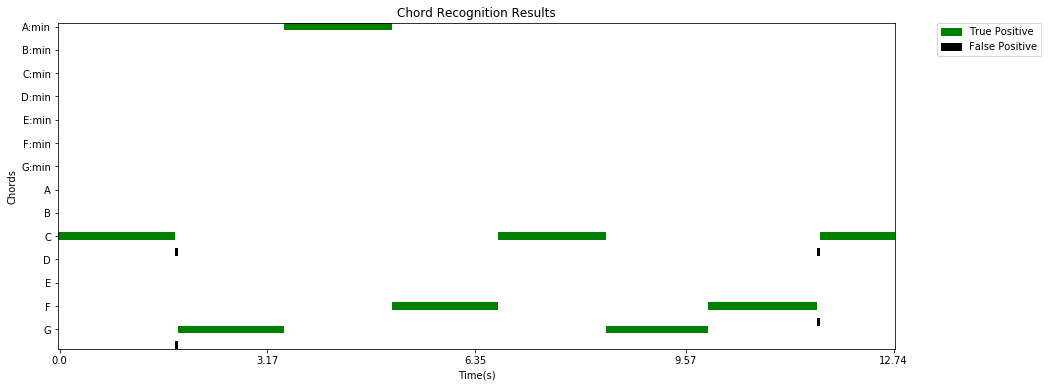

In [18]:
# TODO: Calculate time axis NOT based on frame_duration_sec
def plot_performance(true_positives, false_positives, false_negatives, frame_duration_sec):
    all_chords_list_maj = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
    all_chords_list_min = [f'{elem}:min' for elem in all_chords_list_maj]
    all_chords_list = all_chords_list_min + all_chords_list_maj
    stats_str = ['-TP', '-FP', '-FN']

    key_combination = list(product(all_chords_list, stats_str))
    key_combination = [f'{e1}{e2}' for e1,e2 in key_combination]

    vis_matrix = pd.DataFrame(np.zeros([len(key_combination),true_positives.shape[1]]), index=key_combination)
    vis_matrix.loc[true_positives.index] = vis_matrix.loc[true_positives.index] + true_positives
    vis_matrix.loc[false_positives.index] = vis_matrix.loc[false_positives.index] + false_positives
    vis_matrix.loc[false_negatives.index] = vis_matrix.loc[false_negatives.index] + false_negatives

    plt.figure(figsize=[15,6])
    
    plt.yticks(np.arange(0,vis_matrix.shape[0],3), all_chords_list);
    # generate x-label times in seconds
    xlabel_locations = np.round(np.linspace(0,true_positives.shape[1]-1, 5)).astype(int)
    xlabel_ticks = pd.date_range('2019-01-01', periods=true_positives.shape[1], freq=f'{round(frame_duration_sec * 1000)}ms')
    xlabel_ticks = np.round(xlabel_ticks.second + (xlabel_ticks.microsecond/1000000), 2)
    plt.xticks(xlabel_locations, xlabel_ticks[xlabel_locations])

    plt.xlabel('Time(s)');
    plt.ylabel('Chords');

    plt.title('Chord Recognition Results')

    cmap = colors.ListedColormap(['white', 'green', 'red', 'black'])
    
    im = plt.imshow(vis_matrix, aspect='auto', cmap=cmap)
    
    # https://stackoverflow.com/questions/25482876/how-to-add-legend-to-imshow-in-matplotlib
    # get the colors of the values, according to the 
    # colormap used by imshow
    values = np.unique(vis_matrix.values)
    colors_ = [im.cmap(im.norm(value)) for value in values]
    # create a patch (proxy artist) for every color 
    legend_labels = {1:'True Positive', 2: 'False Positive', 3: 'False Negative'}
    patches = [mpatches.Patch(color=colors_[i], label=legend_labels[i]) for i in range(1,len(values)) ]
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

print(f'F-Score: {round(f1_score_,2)}')
plot_performance(true_positives, false_positives, false_negatives, frame_duration_sec)    


# Execute predictions

Generate MIDI File: https://github.com/louisabraham/python3-midi

In [19]:
def get_chord_notes(chord, chord_type='major'):
    notes = ['A','A#','B','C','C#','D','D#','E','F','F#','G','G#']
    ix_2_notes = {i:notes[i] for i in range(12)}
    notes_2_ix = {notes[i]:i for i in range(12)}
    
    major_steps = [4, 7]
    minor_steps = [3, 7]

    chord_ix_init = np.array(notes_2_ix[chord])
    if(chord_type=='major'):
        steps = chord_ix_init + major_steps
    else:
        steps = chord_ix_init + minor_steps
    
    array_steps = steps%12
    extra_chord_notes = [ix_2_notes[step] for step in array_steps]
    chord_list = [chord] + extra_chord_notes
    return chord_list

get_chord_notes('A', 'minor')

['A', 'C', 'E']

In [20]:
def simplify_predicted_chords(pcp):
    next_values = np.array(pcp['predicted'][1:].tolist() + [np.nan])
    changed_chord = pcp['predicted'] == next_values
    changed_chord_ix = changed_chord[changed_chord == False].index.tolist()

    previous_ix = 0
    begin = []
    end = []
    chord = []
    for changed_chord_ix_ in changed_chord_ix:
        begin.append(pcp['start'][previous_ix])
        end.append(pcp['end'][changed_chord_ix_])
        chord.append(pcp['chord'][changed_chord_ix_])

        previous_ix = changed_chord_ix_+1

    return pd.DataFrame({'start':begin, 'end':end, 'chord':chord})

chords_simplified = simplify_predicted_chords(pcp)
chords_simplified

,start,end,chord
0,0.000000,1.810323,C
1,1.810323,3.481390,G
2,3.481390,5.152458,A:min
3,5.152458,6.777107,F
4,6.777107,8.448174,C
5,8.448174,10.026404,G
6,10.026404,11.743890,C
7,11.743890,12.904354,C


In [21]:
def create_simple_midi(chords_simplified):
    # http://www.music-software-development.com/midi-tutorial.html
    notes = ['A','A#','B','C','C#','D','D#','E','F','F#','G','G#']
    midi_ = [midi.A_4, midi.As_4, midi.B_4, midi.C_4, midi.Cs_4, midi.D_4, midi.Ds_4,
             midi.E_4, midi.F_4, midi.Fs_4, midi.G_4, midi.Gs_4]
    notes_2_midi = {notes_note:midi_note for notes_note, midi_note in zip(notes, midi_)}
    TONIC = 12 # subtract -12 in MIDI = play one octave below

    # Instantiate a MIDI Pattern (contains a list of tracks)
    pattern = midi.Pattern()
    # Instantiate a MIDI Tracks (contains a list of MIDI events)
    track1 = midi.Track()
    track2 = midi.Track()
    track3 = midi.Track()
    tracks = [track1, track2, track3]
    # Append the track to the pattern
    pattern.append(track1)
    pattern.append(track2)
    pattern.append(track3)

    for ix, row in chords_simplified.iterrows():
        chord_type = 'major'

        # get chord notes
        if(len(row['chord']) > 1): # name contains > than 1 letter = minor chord FOR NOW
            chord_type = 'minor'
        chord_notes = get_chord_notes(row['chord'].split(':')[0], chord_type)

        # turn on each chord note
        for i in range(3): 
            if (i == 0):
                pitch = notes_2_midi[chord_notes[i]]-TONIC
            else:
                pitch = notes_2_midi[chord_notes[i]]
            on = midi.NoteOnEvent(tick=0, velocity=100, pitch=pitch)
            tracks[i].append(on)

        # turn off chords event
        for i in range(3): 
            if (i == 0):
                pitch = notes_2_midi[chord_notes[i]]-TONIC
            else:
                pitch = notes_2_midi[chord_notes[i]]
            off = midi.NoteOffEvent(tick=440, pitch=pitch)
            tracks[i].append(off)
    # Add the end of track event, append it to the track
    eot = midi.EndOfTrackEvent(tick=1)
    for i in range(3):
        tracks[i].append(eot)

    # Save the pattern to disk
    midi.write_midifile("example.mid", pattern)
    print('Saved file example.mid')
    
create_simple_midi(chords_simplified)

Saved file example.mid


In [22]:
def execute_midi(path='example.mid'):  
    pygame.init()
    pygame.mixer.music.load(path)
    pygame.mixer.music.play()
# pygame.quit()

In [23]:
def play_prediction(pcp):
    chords_simplified = simplify_predicted_chords(pcp)
    create_simple_midi(chords_simplified)
    execute_midi()
    
play_prediction(pcp)

Saved file example.mid


# Try with whole song

F-Score HMM: 0.71


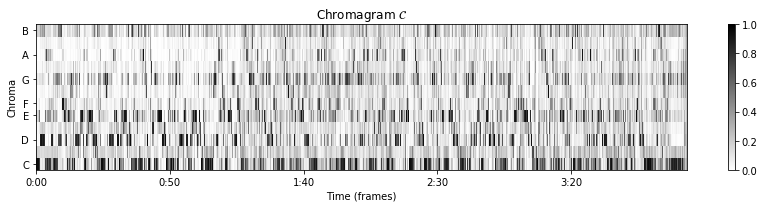

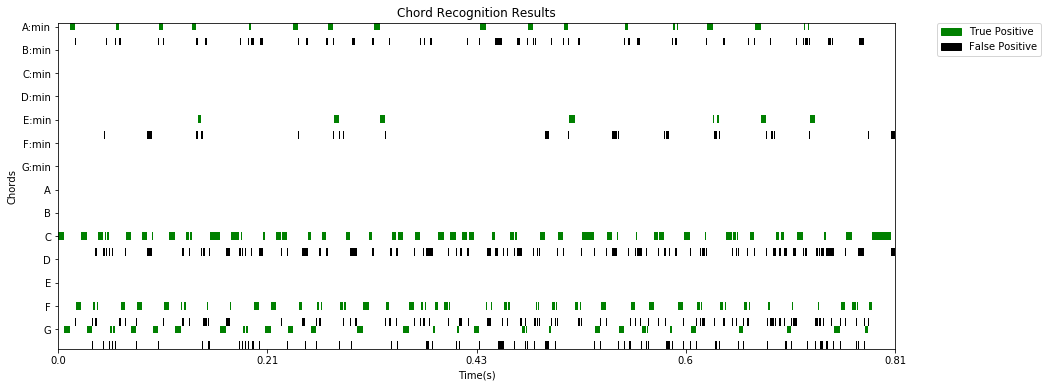

In [24]:
# TODO how to get the annotaded dataset given the sound file? Same name?
def eval_1_whole_song(song_path, plot=True):

    # input data -> signal, sample frequency, chromagram and annotated dataset
    x2, Fs2 = librosa.load(song_path)
    C2 = calc_chromagram(x2, Fs2, plot)
    frames_per_sec, frame_duration_sec = get_frame_stats(C2, x2, Fs2)
    chords_annotation2 = read_simplify_chord_file('06_-_Let_It_Be.lab',process_silence=True)

    pcp2 = pcp_2_dataframe(C2, frame_duration_sec)
    pcp2['chord'] = get_annotated_chord_sequence(pcp2, chords_annotation2)

    ##### HMM parameters
    # Transition Matrix
    transition_matrix2 = calc_transition_prob_matrix(pcp2)
    # Adapted Initial Probability Matrix
    filtered_initial_states2 = adapt_initial_prob_matrix(init_states, transition_matrix2)
    # mu and covariance matrices
    mu_array2, states_cov_matrices2 = get_mu_sigma_from_chroma(pcp2)

    # Build HMM
    h_markov_model2 = build_gaussian_hmm(filtered_initial_states2, transition_matrix2, mu_array2, states_cov_matrices2)

    # get predictions
    chord_ix_predictions2 = h_markov_model2.predict(pcp2[COL_NAMES_NOTES])

    # create map between numerical state index and chord
    ix_2_chord2 = {ix_: chord_str for ix_,chord_str in zip(range(len(mu_array2.index.values)),mu_array2.index.values)}
    pcp2['predicted'] = get_hmm_predictions(chord_ix_predictions2, ix_2_chord2)

    # Evaluate
    true_positives2, false_positives2, false_negatives2, f1_score_2 = calc_classification_stats(pcp2)
    print(f'F-Score HMM: {round(f1_score_2,2)}')
    if(plot == True):
        plot_performance(true_positives2, false_positives2, false_negatives2, frame_duration_sec)
    return pcp2

pcp2 = eval_1_whole_song('Let It Be (Remastered 2009).mp3')

# Trying with training + testing

## Associate all annotation files with corresponding music files

In [25]:
def get_annotation_music_name(annotation_path):   
    separator = ' '
    annotation_path = annotation_path.split('_')[2:]
    annotation_path = separator.join(annotation_path).split('.lab')[0]
    return annotation_path


annotation_files = os.listdir(f'{DEST_FOLDER}')
musics_origin_path = "Beatles"

annotation_paths = []
music_paths = []

for annotation_file in annotation_files:
#     print(f'adding {DEST_FOLDER}/{annotation_file}')
    annotation_paths.append(f'{annotation_file}')
    annotation_file_ = get_annotation_music_name(annotation_file)
    found_music_file = False
    for cd_folder in os.listdir(musics_origin_path):
        cd_folder = f'{musics_origin_path}/{cd_folder}'
#         print(cd_folder)
        if(os.path.isdir(cd_folder)):
            for music_name in os.listdir(cd_folder):
#                 print(f'Comparing {annotation_file_} and {music_name} - {annotation_file_.lower() in music_name.lower()}')
                if(annotation_file_.lower() in music_name.lower()):
#                     print(f'{annotation_file_} !!!! {music_name}')
                    music_paths.append(f'{cd_folder}/{music_name}')
                    found_music_file = True
                    break
        if(found_music_file == True):
            break
    if(found_music_file == False):
        music_paths.append(None)

annotation_2_music = pd.DataFrame({'annotation_path': annotation_paths, 'music_path': music_paths})
annotation_2_music = annotation_2_music.loc[[e is not None for e in annotation_2_music['music_path']]].reset_index(drop=True)

musics_found = np.sum([elem is not None for elem in annotation_2_music['music_path']])

print(f'Number of musics found: {musics_found}')
display(annotation_2_music.head())


Number of musics found: 50


,annotation_path,music_path
0,06_-_Yellow_Submarine.lab,Beatles/The Beatles - One/The Beatles - Yellow...
4,07_-_Ticket_To_Ride.lab,Beatles/Outras/The Beatles - Ticket To Ride.mp3
8,07_-_Hello_Goodbye.lab,Beatles/The Beatles - Magical Mistery Tour/Hel...
10,09_-_Girl.lab,Beatles/THBPMASTER1/03 Thank You Girl.mp3
13,10_-_The_Long_and_Winding_Road.lab,Beatles/The Beatles - One/The Beatles - The lo...


In [120]:
%%time

pcp_final = pd.DataFrame()
music_size_windows = []
individual_pcps = []
for index, m in annotation_2_music.iterrows():
#     input data -> signal, sample frequency, chromagram and annotated dataset
    x2, Fs2 = librosa.load(m['music_path'])
    C2 = calc_chromagram(x2, Fs2, plot=False)
    frames_per_sec, frame_duration_sec = get_frame_stats(C2, x2, Fs2)
    chords_annotation2 = read_simplify_chord_file(m['annotation_path'],process_silence=True)
    
    pcp2 = pcp_2_dataframe(C2, frame_duration_sec)
    pcp2['chord'] = get_annotated_chord_sequence(pcp2, chords_annotation2)
    pcp_final = pd.concat([pcp_final.copy(), pcp2.copy()])
    
    individual_pcps.append(pcp2.copy())
    music_size_windows.append(pcp2.shape[0])
    



CPU times: user 10min 18s, sys: 20 s, total: 10min 38s
Wall time: 10min 28s


In [125]:
trans_probs = calc_transition_prob_matrix(pcp_final)

# Adapted Initial Probability Matrix
filtered_initial_states_all = adapt_initial_prob_matrix(init_states, trans_probs).fillna(0)
# mu and covariance matrices
mu_array_all, states_cov_matrices_all = get_mu_sigma_from_chroma(pcp_final)

# Build HMM
h_markov_model_all = build_gaussian_hmm(filtered_initial_states_all, trans_probs, mu_array_all, states_cov_matrices_all)

# get predictions
for ix, ind_pcp in enumerate(individual_pcps):
    print(annotation_2_music.iloc[ix]['annotation_path'])
    chord_ix_predictions_all = h_markov_model_all.predict(ind_pcp[COL_NAMES_NOTES])

    # create map between numerical state index and chord
    ix_2_chord_all = {ix_: chord_str for ix_,chord_str in zip(range(len(mu_array_all.index.values)),mu_array_all.index.values)}
    ind_pcp['predicted'] = get_hmm_predictions(chord_ix_predictions_all, ix_2_chord_all)

    # Evaluate
    f_ = f1_score(ind_pcp['chord'], ind_pcp['predicted'], average='micro')
    print(f'F-Score HMM: {round(f_,2)}')
    

06_-_Yellow_Submarine.lab
F-Score HMM: 0.36
07_-_Ticket_To_Ride.lab
F-Score HMM: 0.39
07_-_Hello_Goodbye.lab
F-Score HMM: 0.41
09_-_Girl.lab
F-Score HMM: 0.02
10_-_The_Long_and_Winding_Road.lab
F-Score HMM: 0.54
05_-_Your_Mother_Should_Know.lab
F-Score HMM: 0.55
08_-_Within_You_Without_You.lab
F-Score HMM: 0.13
08_-_I've_Got_A_Feeling.lab
F-Score HMM: 0.42
06_-_I_Am_The_Walrus.lab
F-Score HMM: 0.42
13_-_Yesterday.lab
F-Score HMM: 0.26
08_-_Love_Me_Do.lab
F-Score HMM: 0.33
01_-_Help!.lab
F-Score HMM: 0.18
08_-_Eight_Days_a_Week.lab
F-Score HMM: 0.29
06_-_Let_It_Be.lab
F-Score HMM: 0.41
03_-_Flying.lab
F-Score HMM: 0.29
09_-_Penny_Lane.lab
F-Score HMM: 0.65
06_-_The_Word.lab
F-Score HMM: 0.14
03_-_All_My_Loving.lab
F-Score HMM: 0.33
02_-_Eleanor_Rigby.lab
F-Score HMM: 0.31
10_-_Baby_You're_A_Rich_Man.lab
F-Score HMM: 0.4
02_-_The_Fool_On_The_Hill.lab
F-Score HMM: 0.22
07_-_Here_Comes_The_Sun.lab
F-Score HMM: 0.2
14_-_Tomorrow_Never_Knows.lab
F-Score HMM: 0.06
08_-_Strawberry_Fields_Forev

# Next Steps

* Make a beat recognition system in order to adapt the predicted chords into it, 1 chord per 1,2,3 or 4 beats eg.
* Insert predicted beats in the MIDI file creation - currently with fixed time size chord play
* Errors come mainly from chord transitions and there are already some approaces such as chromagram smoothing that try to improve the problem
* Evaluate the chord recognition performance without the presence of voices or percussions or even bass
    * How would the bass be a chord predictor actually?
* Incorporate music tonal key or cadences when calculating transition probability matrix

## Next Neeeext Step

* Extract lyrics from websites and insert them into the beat + chord structure and produce a pdf with lyrics + chords
* Could we use music websites as annotaded chord songs? We would need to find a way to match the written chords with time beats and use them as proxy for chord start and end annotation.
    * With the bigger amount of songs, we could even think on LSTMs for chord prediction


# Appendix

## Mathematical formulation for the decoding part of Hidden Markov Models

Given the following components:

* $Q = q_{1}q_{2}...q_{M}$ A set of $M$ **states**
* $A = a_{11}..a{ij}...a_{MM}$ A **transition probability matrix** for the $M$ states. The index $a_{ij}$ represent the transition probability between state $i$ to state $j$
* $O = o_{1}o_{2}...o_{N}$ A set of $N$ **observations**
* $B=b_{i}(j)$ **Emissions probabilities** indicating $P(o_{i}|s_{i})$, the probability of an observation $j$ being generated by state $i$
  
In this task, the states are the chords and the observations are the windowed chromagram.

With a HMM, the challenge of finding the best sequence of chord -$seq_{chords}$- given the observations we have is:  
  
$$seq_{chords} = \underset{seq_{chords}}{arg\_max}\mathbb{P}(seq_{chords}|O) \space \space \space (1)$$  
  
Using Bayes' rule on this, it becomes:

$$seq_{chords} = \underset{seq_{chords}}{arg\_max}\frac{\mathbb{P}(O|seq_{chords})\mathbb{P}(seq_{chords})}{\mathbb{P}(O)} \propto \underset{seq_{chords}}{arg\_max}\mathbb{P}(O|seq_{chords})\mathbb{P}(seq_{chords}) \space \space \space (2)$$  

Considering a first order markov chain, we can define two properties:  
  
(1) **Markov Assumption**: The probability of observing a given chord given its previous chord only depends on its immediately previous chord: $\mathbb{P}(chord_{i} | chord_{1}, ..., chord_{i-1}) = \mathbb{P}(chord_{i}|chord_{i-1})$. **That means**, in equation 2: $\mathbb{P}(seq_{chords}) = \prod_{i=1}^{N} \mathbb{P}(chord_{i}|chord_{i-1})$
  
(2) **Output independence**: The probability of observing $obs_{i}$ only depends on the immediate state $chord_{i}$ and not on previous or future observations\states: $\mathbb{P}(obs_{i}|chord_{1},...,chord_{i},...,chord_{t}, obs_{1},...,obs_{i},...,obs_{t}) = \mathbb{P}(obs_{i} |chord_{i})$. **That means**, in equation 2: $\mathbb{P}(O|seq_{chords}) = \prod_{i=1}^{N} \mathbb{P}(obs_{i}|chord_{i})$  

Substituting the terms in equation 2 by the assumptions, we have: 
  
$$seq_{chords} = \underset{seq_{chords}}{arg\_max}\mathbb{P}(seq_{chords}|O) = \underset{seq_{chords}}{arg\_max}\prod_{i=1}^{N}\mathbb{P}(obs_{i}|chord_{i})\mathbb{P}(chord_{i}|chord_{i-1}) \space \space \space (3)$$  
  
  
Given then a sequence of $N$ observations and sequence of $N$ states (with $M$ possible values), supposedly we juset need to try them all and choose the one that maximizes our probability.  
  
You can already imagine that trying out **all** possible chord sequences might become unfeasible when the number of observations grows. For N observations and M possible states for each, we'll have a total of $M^{N}$ possible sequences. In our windowed music signals, N > 1000 and M = 24 so the number of possible sequences is $24^{1000}$.  

In order not to visit all possible sequence possibilities, we need an algorithm to maximize our probability in an efficient way and the way we solve it is using the [Viterbi Algorithm](http://cecas.clemson.edu/~ahoover/ece854/refs/Gonze-ViterbiAlgorithm.pdf). For a detailed example, you can check it out [here](https://www.youtube.com/watch?v=kqSzLo9fenk&t=1746s).
